In [41]:
import pandas as pd
import numpy as np
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import chain
import patsy
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import glob 
%matplotlib inline

In [42]:
infiles = glob.glob("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/PHEWAS/phecodes_gwassamp/f*.csv")

In [43]:
infiles = sorted(infiles,key=(lambda e: int(e.split("/")[-1].split("_")[0][1:])))

In [44]:
phecodeinfo = pd.read_table('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/PHEWAS/UKB_Phecode_v1.2b1_ICD_Mapping.txt').set_index("phecode")

In [45]:
import scipy.stats as st

In [46]:
bonf = 0.05/(403*35)

In [47]:
crit_z = st.norm.ppf(1-(bonf/2))

In [48]:
outcols = ["phecode","name","group","n","n_case","or","coef","se","z","p"]

In [49]:
for file in infiles:
    factor = file.split("/")[-1].split(".")[0]
    temp = pd.read_csv(file)
    temp["abs_teststat"] = abs(temp.teststat)
    temp["group"] = temp.apply(lambda x: phecodeinfo.loc[x["Unnamed: 0"]].group,axis=1)
    temp["or"] = temp.apply(lambda x: np.exp(x.coef),axis=1)
    temp = temp[temp.p<bonf].sort_values("p")
    temp.rename(columns={'Unnamed: 0':'phecode','teststat':'z'}, inplace=True)
    break

In [50]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [51]:
for i,file in enumerate(infiles):
    factor = file.split("/")[-1].split(".")[0]
    temp = pd.read_csv(file)
    temp["abs_teststat"] = abs(temp.teststat)
    temp["group"] = temp.apply(lambda x: phecodeinfo.loc[x["Unnamed: 0"]].group,axis=1)
    temp["toplevel"]=temp.apply(lambda x: str(x["Unnamed: 0"]).split(".")[1]=="0",axis=1)
    temp = temp[temp.toplevel]
    temp = temp.sort_values(["group","Unnamed: 0"])
    temp_trimmed = temp[temp["abs_teststat"]<1000].reset_index()
    break

In [52]:
colordict = dict(zip(temp_trimmed.group.unique(),px.colors.qualitative.Light24[0:16]))

In [53]:
temp.shape

(403, 15)

In [54]:
colors_dark = px.colors.qualitative.Dark24[0:16]

In [55]:
from matplotlib.colors import hsv_to_rgb, to_hex

In [56]:
from colormap import rgb2hex, rgb2hls, hls2rgb

In [57]:
def hex_to_rgb(hex):
     hex = hex.lstrip('#')
     hlen = len(hex)
     return tuple(int(hex[i:i+hlen//3], 16) for i in range(0, hlen, hlen//3))

def adjust_color_lightness(r, g, b, factor):
    h, l, s = rgb2hls(r / 255.0, g / 255.0, b / 255.0)
    l = max(min(l * factor, 1.0), 0.0)
    r, g, b = hls2rgb(h, l, s)
    return rgb2hex(int(r * 255), int(g * 255), int(b * 255))

def darken_color(rgb, factor=0.5):
    r, g, b = rgb
    return adjust_color_lightness(r, g, b, 1 - factor)

In [58]:
from matplotlib.lines import Line2D
import scipy

In [59]:
import math

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


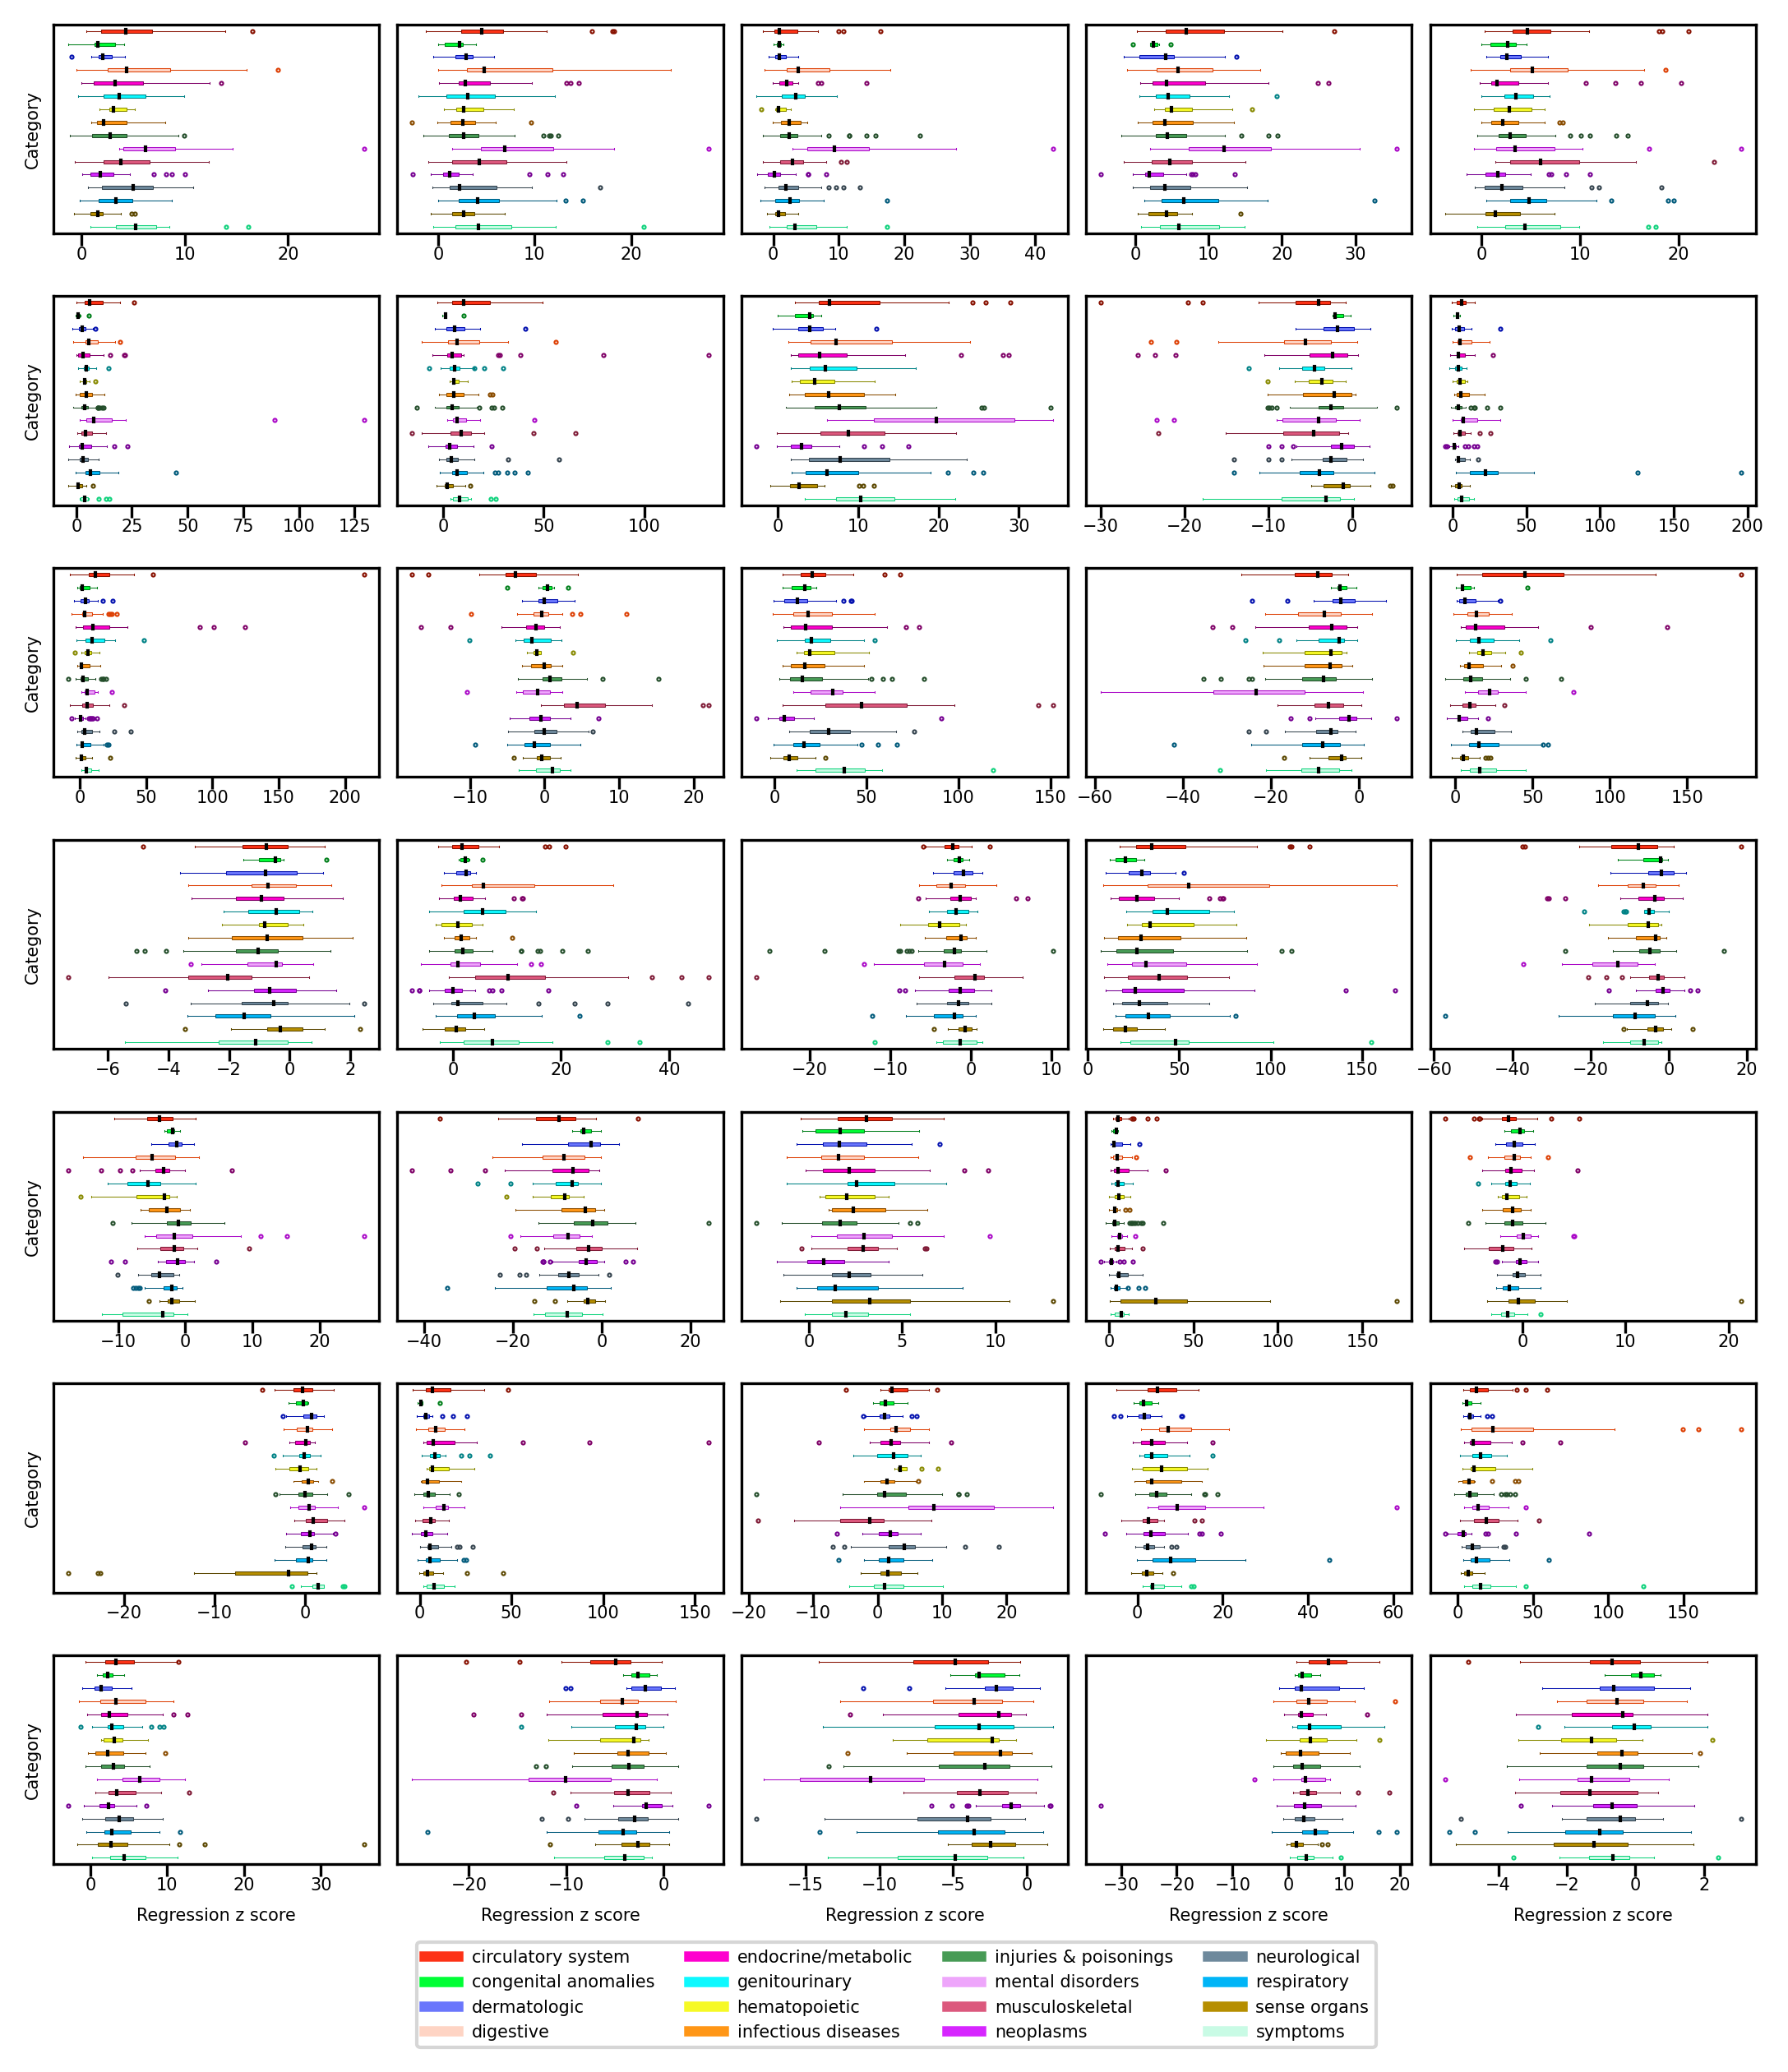

In [60]:
fig, axes = plt.subplots(8, 5, figsize=(7.086,8.267), dpi=300, gridspec_kw={'height_ratios':[1,1,1,1,1,1,1,0.6]})
for j,file in enumerate(infiles):
    # fig.add_subplot(8,5,j+1)
    factor = file.split("/")[-1].split(".")[0].split("_")[0].upper()
    temp = pd.read_csv(file)
    temp["abs_teststat"] = abs(temp.teststat)
    temp["group"] = temp.apply(lambda x: phecodeinfo.loc[x["Unnamed: 0"]].group,axis=1)
    temp["toplevel"]=temp.apply(lambda x: str(x["Unnamed: 0"]).split(".")[1]=="0",axis=1)
    temp = temp[temp.toplevel]
    temp = temp.sort_values(["group","Unnamed: 0"])
    temp_trimmed = temp[temp["abs_teststat"]<100000000000].reset_index()
    #temp_trimmed["log10p"] = -np.log10(scipy.stats.norm.sf(temp["teststat"]))
    bp_dict = temp_trimmed.boxplot(column=["teststat"],by="group",patch_artist=True,grid=False,return_type='both',ax=axes[math.floor(j / 5),j % 5],vert=False,widths=0.25)
    colors = px.colors.qualitative.Light24[0:16]
    colors_dark = [darken_color(hex_to_rgb(hex_number)) for hex_number in colors]
    colors_dark2 = np.repeat([darken_color(hex_to_rgb(hex_number)) for hex_number in colors],2)
    for row_key, (ax,row) in bp_dict.iteritems():
        for i,box in enumerate(row['boxes']):
            box.set_color(colors_dark[i])
            box.set_facecolor(colors[i])
            box.set_linewidth(0.25)
        for i,whisker in enumerate(row['whiskers']):
            whisker.set_color(colors_dark2[i])
            whisker.set_linewidth(0.25)
        for i,cap in enumerate(row['caps']):
            cap.set_color(colors_dark2[i])
            cap.set_linewidth(0.25)
        for i,flier in enumerate(row['fliers']):
            flier.set_markerfacecolor("none")
            flier.set_marker(".")
            flier.set_markersize(1)
            flier.set_markeredgecolor(colors_dark[i])
        for i,median in enumerate(row['medians']):
            median.set_color("k")
    #lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
    #labels = colordict.keys()
    plt.title(factor, size=6, pad=0.5)
    plt.suptitle("")
    plt.axvline(x=crit_z, linestyle="--", color="black",alpha=0.25,zorder=0,lw=0.75)
    plt.axvline(x=-1*crit_z, linestyle="--", color="black",alpha=0.25,zorder=0,lw=0.75)
    plt.axvline(x=0, linestyle="-", color="black",alpha=0.25,zorder=0,lw=0.75)
    #plt.legend(lines,labels,loc='center left', bbox_to_anchor=(1, 0.63))
    # ax = plt.gca()
    
    # plt.xlim(-1.05*max(temp["abs_teststat"]), 1.05*max(temp["abs_teststat"]))
    # plt.xlim(-75,210)

    #hide x-axis   
    if(math.floor(j / 5) == 6):
        axes[math.floor(j / 5),j % 5].set_xlabel("Regression z score", size=5)
    else:
        axes[math.floor(j / 5),j % 5].set_xlabel("")
    
    # ax.get_yaxis().set_visible(False) 
    axes[math.floor(j / 5),j % 5].yaxis.set_tick_params(labelleft=False)
    axes[math.floor(j / 5),j % 5].set_yticks([])
    if(math.floor(j % 5) == 0):
        axes[math.floor(j / 5),j % 5].set_ylabel("Category", size=5, labelpad=0.025)
    axes[math.floor(j / 5),j % 5].invert_yaxis()
    
    axes[math.floor(j / 5),j % 5].tick_params(axis='both', which='major', labelsize=5,pad=0.25)
    
    axes[math.floor(j / 5),j % 5].title.set_visible(False)
    
for k in range(0,5):
    axes[7,k].set_visible(False)
    


fig.legend([Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors],colordict.keys(),bbox_to_anchor=(0.78,0.06),ncol=4, fontsize=5)
plt.subplots_adjust(hspace=0.05, wspace=0.05)
fig.tight_layout(pad=0.1)

#fig.update_layout(yaxis_range=[0,60])
    #display(temp_trimmed.sort_values("abs_teststat",ascending=False)[0:10][["name","teststat"]])

plt.savefig("/stanley/robinson/ccarey/factor_paper_revision/edfigs_CEC/EDFig4.eps") # bbox_inches="tight", pad_inches=0)